In [5]:

#실제데이터에 넣어보기

import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel as nib
from scipy import stats

# 디바이스 설정
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

# 모델 불러오기
model = UNet().to(device).float()
model.load_state_dict(torch.load('./UNet3.pth', map_location=device))
model = model.to(device)
model.eval()

# 데이터 불러오기
test_load = nib.load('./armotor_2894.nii')
raw_data = test_load.get_fdata()
eps = 1e-8

In [6]:
# 결과를 저장할 빈 리스트 생성
results = []

# 모델에 데이터를 입력하고 결과 저장
with torch.no_grad():
    for i in range(raw_data.shape[0]):
        for j in range(raw_data.shape[1]):
            for k in range(raw_data.shape[2]):
                mean = np.mean(raw_data[i,j,k, :])
                std_dev = np.std(raw_data[i,j,k, :]) + eps
                data = (raw_data[i,j,k,:] - mean) / std_dev
                data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).float()
                data = padding(data)
                data = data.to(device)
                output = model(data) * std_dev + mean
                output = output[:,:,:-6]
#output = output*std_dev+mean
                results.append(output.cpu().squeeze().numpy())

# 결과를 128x128x33x90 형태로 변환

results_reshape = np.array(results).reshape(128, 128, 33, 90)

# 결과를 Nifti 파일로 저장
result_img = nib.Nifti1Image(results_reshape, test_load.affine)
nib.save(result_img, './norm_unnorm_armotor_result.nii')

In [5]:
!nvidia-smi

Fri Mar 22 06:08:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 48%   41C    P2   109W / 320W |   4973MiB / 10018MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 48%   

<class 'numpy.memmap'>
(128, 128, 33, 90)


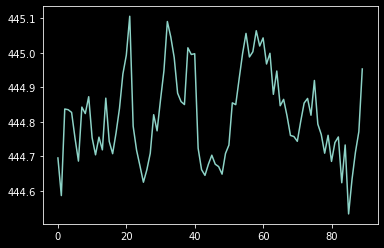

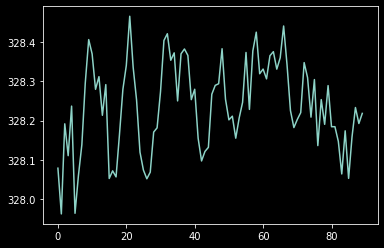

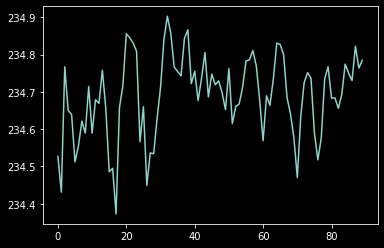

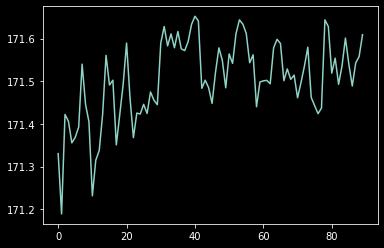

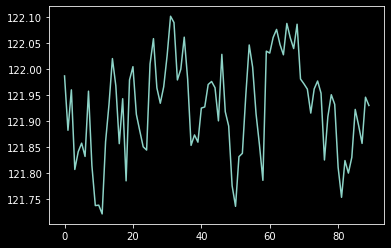

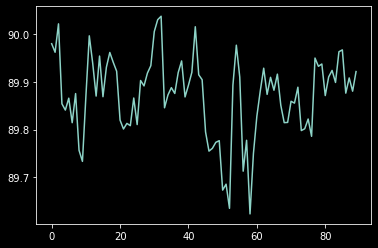

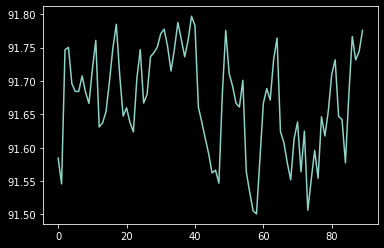

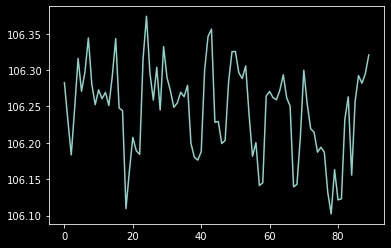

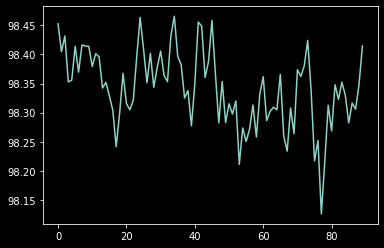

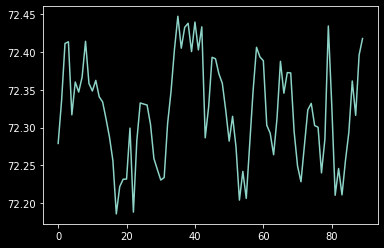

In [5]:
#학습된 데이터 확인.
import nibabel as nib
import matplotlib.pyplot as plt
trained_data = nib.load('./norm_unnorm_armotor_result.nii').get_fdata()
print(type(trained_data))
print(trained_data.shape)

for i in range(10):
    plt.plot(trained_data[70,60+i,9,:])
    plt.show()

In [1]:
#design matrix 및 glm score측정
import os
import torch
import numpy as np
import torch.nn.functional as F
import math
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import  TensorDataset, DataLoader
import scipy.io
import cmath                

from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d,gaussian_filter
from PIL import Image
import torchvision.transforms as transforms

import nibabel as nib
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.image import concat_imgs, mean_img, resample_img
import nilearn
import pandas
from nifti_utils import *
from nilearn import image as nli

def create_design_matrix(tr=3, n_scans=90, a=0, csv=None):
    tr = 3  # repetition time is 1 second
    n_scans = n_scans  # the acquisition comprises 90 scans
    frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times
    if csv==None:
        # these are the types of the different trials
        conditions = ["c0", "c0"]
        duration = [60, 60]
        onsets = [90, 210]
            

        events = pd.DataFrame(
            {"trial_type": conditions, "onset": onsets, "duration": duration}
        )
    else:
        selected_columns = ["emotion", "correct_stim_onset_time", "duration"]
        selected_data = csv[selected_columns].copy()
        selected_data['emotion'] = selected_data['emotion'].astype(str).replace({'rest': 'off', '0': 'on', '1': 'on'})

    hrf_model = "glover"
    X1 = make_first_level_design_matrix(
        frame_times,
        events,
        drift_model="polynomial",
        drift_order=3,
        hrf_model=hrf_model,
    )
    return X1


def calculate_glm(data,mask_slice=None,csv=None,a=0, percentage=None, threshold=0.1,cut_coords=3,mod=178, masking=False, plot=True,annotate=False,colorbar=True,fig=None,ax=None):
    
    X1=create_design_matrix(tr=3, n_scans=90, a=0, csv=csv)
    

    # # duration = 7.0 * np.ones(len(conditions))
    # events = pd.DataFrame(
    #     {"trial_type": conditions, "onset": onsets, "duration": duration}
    # )

    fmri_glm = FirstLevelModel(t_r=3, hrf_model = "glover")
    fmri_glm = fmri_glm.fit(data, design_matrices=X1)

    contrast_matrix = np.eye(X1.shape[1])
    basic_contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(X1.columns)
    }
    
    z_map = fmri_glm.compute_contrast(X1.columns[0], output_type="stat")
    if percentage!=None:
        z_map=cutoff_nii(z_map,percentage)
        # print(z_map)
        threshold=0
    plt.style.use('dark_background')
    if fig==None:
        fig=plt.figure(figsize=(36,6))
    # plt.figure(figsize=(6,6))
    # print(nilearn.masking.compute_epi_mask(mean_img(data),mask_slice).shape)
    if masking==True:
        background_img=apply_mask(mean_img(data),mask_slice)
    else: 
        background_img=mean_img(data)
    if plot==True:
        plotting.plot_stat_map(z_map,
                                bg_img=background_img,
                                threshold=threshold,
                                display_mode="z",
                                cut_coords=6,
                                black_bg=True,
                                figure=fig,
                                annotate=annotate,
                                colorbar=colorbar
                                )
    plt.show()
    plt.pause(0.005)
    
    return z_map,data



    

/home/milab/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Index(['c0', 'drift_1', 'drift_2', 'drift_3', 'constant'], dtype='object')


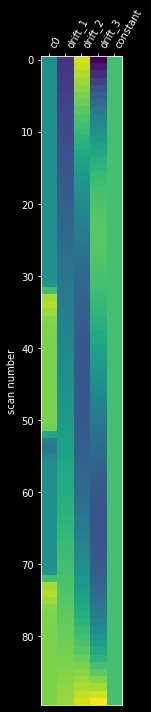

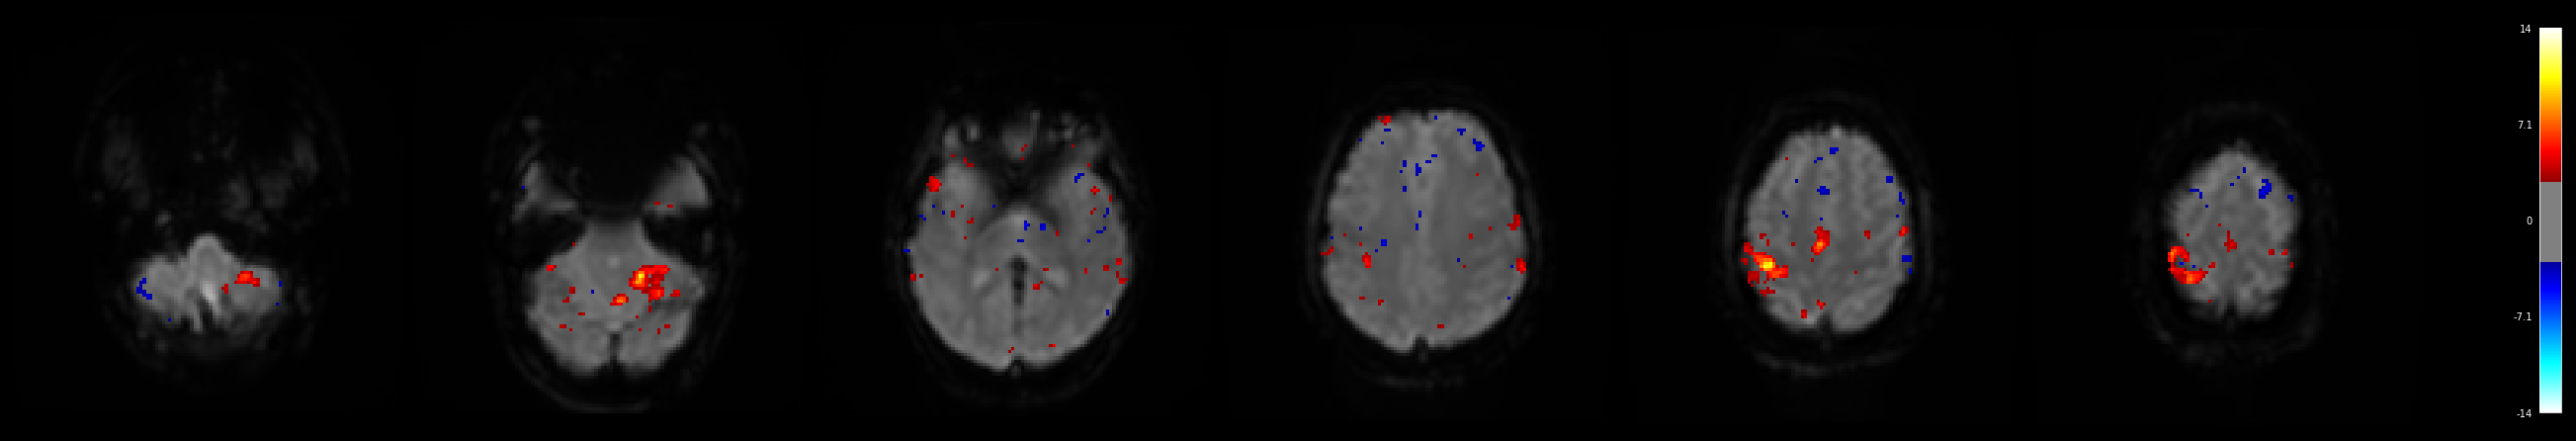

In [11]:
#Showing design matrices
from nilearn.plotting import plot_design_matrix
import nibabel as nib
import numpy as np
import fmri_utils_true

design_matrices = create_design_matrix(tr = 3 ,n_scans = 90)
plot_design_matrix(design_matrices)

print(design_matrices.columns)


bold = nib.load('./norm_unnorm_armotor_result.nii')
#bold = nib.load('./armotor_2894.nii')

z_map,data=calculate_glm(bold ,threshold=3,plot=True,colorbar=True,mod=90)



Index(['c0', 'drift_1', 'drift_2', 'drift_3', 'constant'], dtype='object')


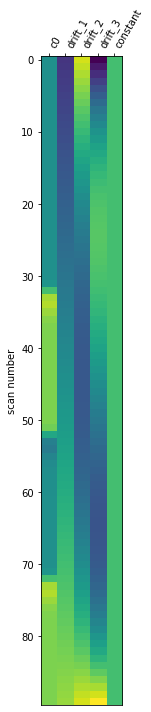

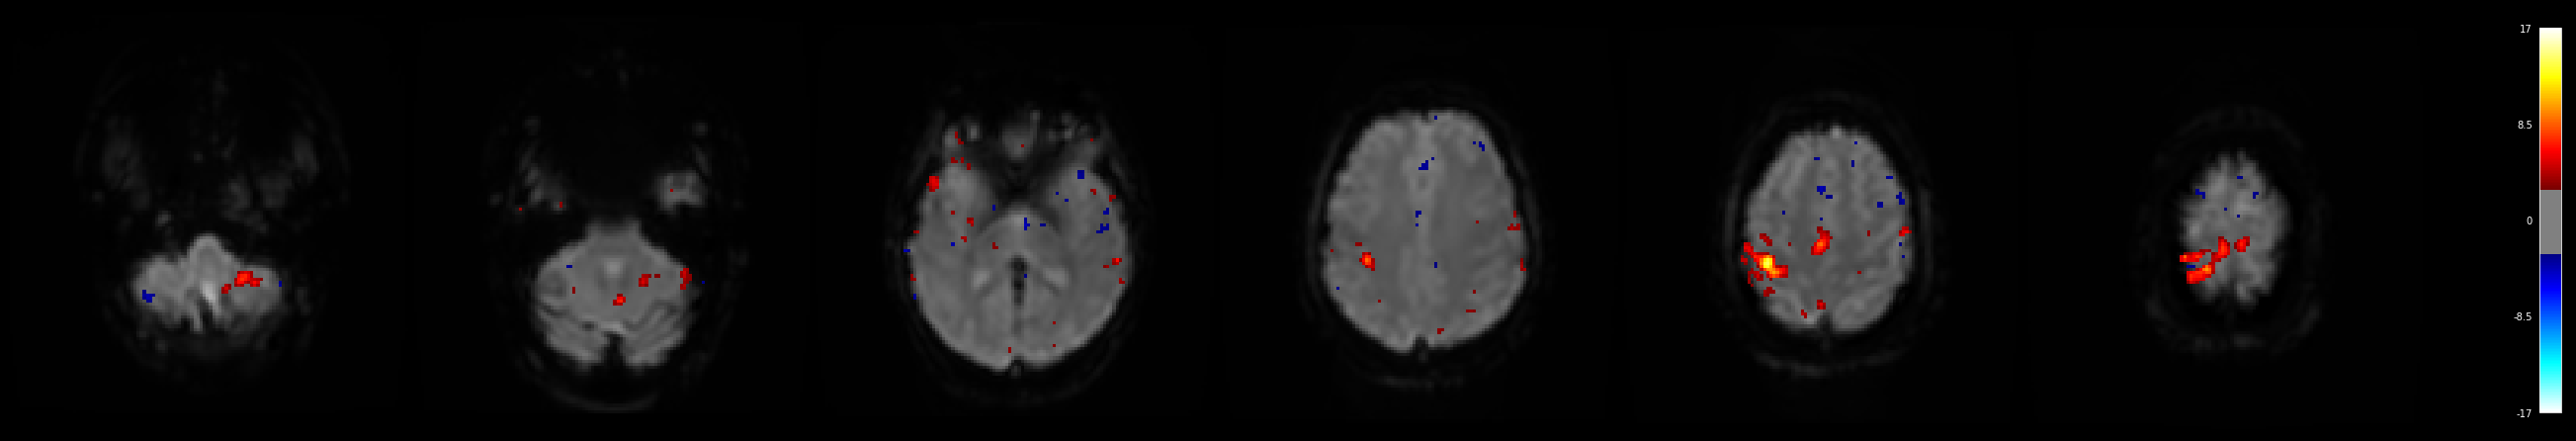

In [2]:
#Showing design matrices
from nilearn.plotting import plot_design_matrix
import nibabel as nib
import numpy as np
import fmri_utils_true

design_matrices = create_design_matrix(tr = 3 ,n_scans = 90)
plot_design_matrix(design_matrices)

print(design_matrices.columns)


#bold = nib.load('./norm_unnorm_armotor_result.nii')
bold = nib.load('./armotor_2894.nii')

z_map,data=calculate_glm(bold ,threshold=3,plot=True,colorbar=True,mod=90)



In [2]:
import torch.nn as nn
import torch
from torch.nn import ConstantPad1d
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1_1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc2_1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc3_1 = nn.Conv1d(128, 256, kernel_size = 3, padding=1)
        self.enc3_2 = nn.Conv1d(256, 256, kernel_size = 3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc4_1 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv1d(1024, 512, kernel_size=3, padding=1)
        
        self.upsample4 = nn.ConvTranspose1d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv1d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        
        self.upsample3 = nn.ConvTranspose1d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv1d(256,128, kernel_size=3, padding=1)
        
        self.upsample2 = nn.ConvTranspose1d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        
        self.upsample1 = nn.ConvTranspose1d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv1d(64, 1, kernel_size=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1) 
        

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2) 

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3) 
        
     
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4) 
      
        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
        
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
        
        x = self.upsample3(x) 
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)
        
      
        return x
'''
    def _make_layers(self, in_c, out_c, n_conv):
        layers = []
        for i in range(n_conv):
            layers.append(nn.Conv1d(in_c, out_c, kernal_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            in_c = out_c

        return nn.Sequential(*layers) 
'''               
padding = ConstantPad1d((0, 6), 0)  #padding with zero
